In [1]:
import sys
sys.path.append("..")

from skimage import io
import pandas as pd
from utilsN.readClasses import readDoryImg
import matplotlib.pyplot as plt
from math import sqrt
import numpy as np
from Guidestar_colocalisation.frequencyFilter import butter2d
from skimage.feature import peak_local_max


def norm_image_func(image):
    """" Params: image (2 or 3D arr)
         Return: normalise image arr by min = 0 and max = 1 (2 or 3D arr)
    """
    image_max = np.max(image)
    image_min = np.min(image)
    print("minimum intensity of image =", image_min)
    print("maximum intensity of image =", image_max)
    return (image - image_min) / (image_max - image_min)

def filter_func(filter_param, img_arr):
    freq_filter = butter2d(low_cut=filter_param[0], high_cut=filter_param[1],
                           order=2, xdim=img_arr.shape[1], ydim=img_arr.shape[1])
    filter_shifted = np.fft.fftshift(freq_filter)
    img_fourier = np.fft.fftn(img_arr)
    filtered_img = np.fft.ifftn(img_fourier * filter_shifted)
    return filtered_img.real

Text(0.5, 1.0, 'MERFISH Cy5 image')

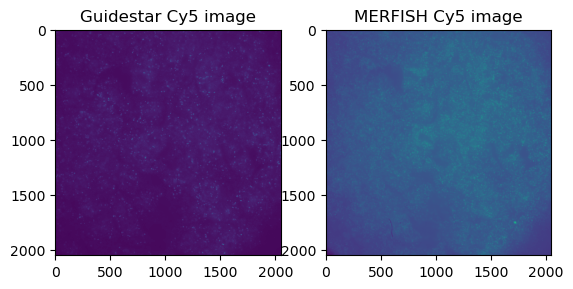

In [ ]:
fov = 15
GS_cy5 = readDoryImg('/path_to_raw_data/Cy5_01_' + str(fov).zfill(2) + '.dax')
MERFISH_cy5 = readDoryImg('/path_to_raw_data/Cy5_02_' + str(fov).zfill(2) + '.dax')

plt.subplot(1,2,1)
plt.imshow(GS_cy5)
plt.title('Guidestar Cy5 image')

plt.subplot(1,2,2)
plt.imshow(MERFISH_cy5)
plt.title('MERFISH Cy5 image')

In [3]:
GS_cy5_norm = norm_image_func(GS_cy5)
GS_cy5_filtered = filter_func([300,None], GS_cy5_norm)

MERFISH_cy5_norm = norm_image_func(MERFISH_cy5)
MERFISH_cy5_filtered = filter_func([300,None], MERFISH_cy5_norm)

minimum intensity of image = 676
maximum intensity of image = 27224
Mid point of filter: y = 1023.500, x = 1023.500
Filter path not provided. Not saving filter
minimum intensity of image = 582
maximum intensity of image = 3624
Mid point of filter: y = 1023.500, x = 1023.500
Filter path not provided. Not saving filter


Text(0.5, 1.0, 'Filtered MERFISH Cy5 image')

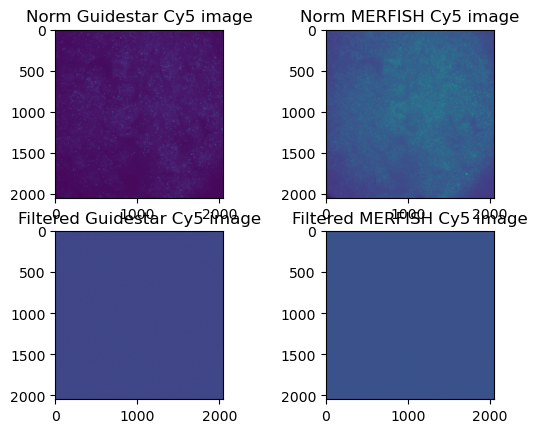

In [4]:
plt.subplot(2,2,1)
plt.imshow(GS_cy5_norm)
plt.title('Norm Guidestar Cy5 image')

plt.subplot(2,2,2)
plt.imshow(MERFISH_cy5_norm)
plt.title('Norm MERFISH Cy5 image')

plt.subplot(2,2,3)
plt.imshow(GS_cy5_filtered)
plt.title('Filtered Guidestar Cy5 image')

plt.subplot(2,2,4)
plt.imshow(MERFISH_cy5_filtered)
plt.title('Filtered MERFISH Cy5 image')

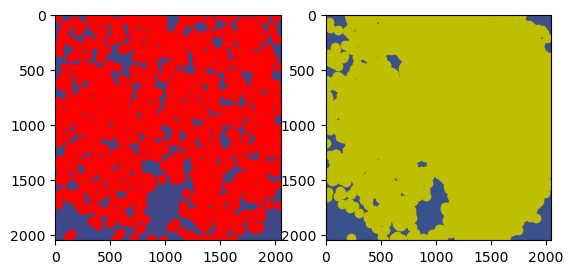

In [5]:
coordinates_GS_cy5 = peak_local_max(GS_cy5_filtered, min_distance=2, threshold_rel=0.07)
coordinates_MERFISH_cy5 = peak_local_max(MERFISH_cy5_filtered, min_distance=2, threshold_rel=0.18)

plt.subplot(1,2,1)
plt.imshow(GS_cy5_filtered)
plt.plot(coordinates_GS_cy5[:, 1], coordinates_GS_cy5[:, 0], 'ro')

plt.subplot(1,2,2)
plt.imshow(MERFISH_cy5_filtered)
plt.plot(coordinates_MERFISH_cy5[:, 1], coordinates_MERFISH_cy5[:, 0], 'yo')

SNR Guidestar: 4.029407259381208
SNR MERFISH: 1.486275739718093


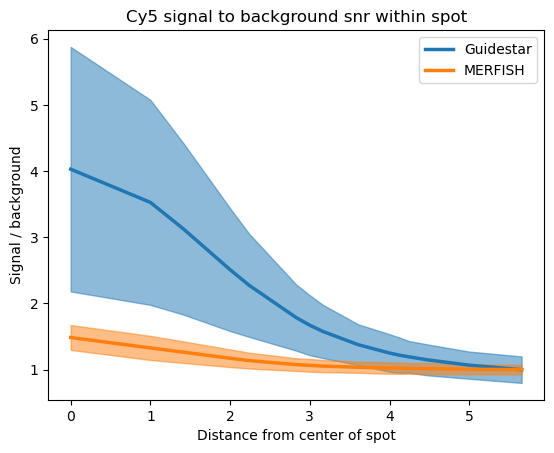

In [ ]:
sample_size = 500

GS_intensities_region = []
GS_dists_region = []
MERFISH_intensities_region = []
MERFISH_dists_region = []

filtered_GS_cy5_coords = coordinates_GS_cy5[np.logical_and(coordinates_GS_cy5 >= 20, coordinates_GS_cy5 <= 2028).all(axis=1)]
filtered_MERFISH_cy5_coords = coordinates_MERFISH_cy5[np.logical_and(coordinates_MERFISH_cy5 >= 20, coordinates_MERFISH_cy5 <= 2028).all(axis=1)]

coordinates_GS_cy5_sample = filtered_GS_cy5_coords[np.random.choice(filtered_GS_cy5_coords.shape[0], sample_size, replace=False)]
coordinates_MERFISH_cy5_sample = filtered_MERFISH_cy5_coords[np.random.choice(filtered_MERFISH_cy5_coords.shape[0], sample_size, replace=False)]

for spot in range(sample_size):
    y_GS = coordinates_GS_cy5_sample[spot,1]
    x_GS = coordinates_GS_cy5_sample[spot,0]
    y_MERFISH = coordinates_MERFISH_cy5_sample[spot,1]
    x_MERFISH = coordinates_MERFISH_cy5_sample[spot,0]
    
    GS_intensities_region_spot = []
    GS_dists_region_spot = []
    MERFISH_intensities_region_spot = []
    MERFISH_dists_region_spot = []
    
    for x_px in range(x_GS-4,x_GS+5):
        for y_px in range(y_GS-4,y_GS+5):
            px_intensity = GS_cy5_norm[x_px,y_px]
            px_dist = sqrt(np.power(y_GS-y_px,2)+np.power(x_GS-x_px,2))
            
            GS_intensities_region_spot.append(px_intensity)
            GS_dists_region_spot.append(px_dist)
            
    for x_px in range(x_MERFISH-4,x_MERFISH+5):
        for y_px in range(y_MERFISH-4,y_MERFISH+5):
            px_intensity = MERFISH_cy5_norm[x_px,y_px]
            px_dist = sqrt(np.power(y_MERFISH-y_px,2)+np.power(x_MERFISH-x_px,2))
            
            MERFISH_intensities_region_spot.append(px_intensity)
            MERFISH_dists_region_spot.append(px_dist)
            
    spot_GS_df = pd.DataFrame({'intensity':GS_intensities_region_spot,'dist':GS_dists_region_spot})
    spot_MERFISH_df = pd.DataFrame({'intensity':MERFISH_intensities_region_spot,'dist':MERFISH_dists_region_spot})
    spot_GS_df['snr'] = spot_GS_df['intensity'] / spot_GS_df['intensity'].loc[spot_GS_df['dist']==spot_GS_df['dist'].max()].mean()
    spot_MERFISH_df['snr'] = spot_MERFISH_df['intensity'] / spot_MERFISH_df['intensity'].loc[spot_MERFISH_df['dist']==spot_MERFISH_df['dist'].max()].mean()
    
    GS_intensities_region.extend(spot_GS_df['snr'].tolist())
    GS_dists_region.extend(spot_GS_df['dist'].tolist())
    MERFISH_intensities_region.extend(spot_MERFISH_df['snr'].tolist())
    MERFISH_dists_region.extend(spot_MERFISH_df['dist'].tolist())

GS_df = pd.DataFrame({'intensity':GS_intensities_region,'dist':GS_dists_region})
MERFISH_df = pd.DataFrame({'intensity':MERFISH_intensities_region,'dist':MERFISH_dists_region})

GS_avg_intensity = []
MERFISH_avg_intensity = []

GS_std_intensity = []
MERFISH_std_intensity = []

dist_ls = []

for d in np.unique(GS_dists_region):
    dist_ls.append(d)
    GS_avg_intensity.append(GS_df['intensity'].loc[GS_df['dist']==d].mean())
    MERFISH_avg_intensity.append(MERFISH_df['intensity'].loc[MERFISH_df['dist']==d].mean())
    
    GS_std_intensity.append(GS_df['intensity'].loc[GS_df['dist']==d].std())
    MERFISH_std_intensity.append(MERFISH_df['intensity'].loc[MERFISH_df['dist']==d].std())

GS_avg_intensity = np.array(GS_avg_intensity)
GS_std_intensity = np.array(GS_std_intensity)
MERFISH_avg_intensity = np.array(MERFISH_avg_intensity)
MERFISH_std_intensity = np.array(MERFISH_std_intensity)
      
fig,ax=plt.subplots() 
ax.plot(dist_ls,GS_avg_intensity,color='tab:blue', label='Guidestar', linewidth = 2.5)
ax.plot(dist_ls,MERFISH_avg_intensity,color='tab:orange', label='MERFISH', linewidth = 2.5)

ax.fill_between(dist_ls,GS_avg_intensity-GS_std_intensity,GS_avg_intensity+GS_std_intensity,color='tab:blue',alpha=0.5)
ax.fill_between(dist_ls,MERFISH_avg_intensity-MERFISH_std_intensity,MERFISH_avg_intensity+MERFISH_std_intensity,color='tab:orange',alpha=0.5)

ax.set_xlabel('Distance from center of spot')
ax.set_ylabel('Signal / background')
ax.legend(loc='upper right')
ax.set_title('Cy5 signal to background snr within spot')

# SNR at center of spot (distance 0)
print('SNR Guidestar:', GS_avg_intensity[0])
print('SNR MERFISH:', MERFISH_avg_intensity[0])


Text(0.5, 1.0, 'MERFISH Cy7 image')

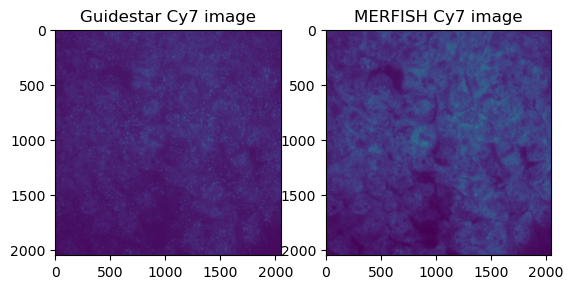

In [ ]:
fov = 15
GS_cy7 = readDoryImg('/path_to_raw_data/Cy7_01_' + str(fov).zfill(2) + '.dax')
MERFISH_cy7 = readDoryImg('/path_to_raw_data/Cy7_02_' + str(fov).zfill(2) + '.dax')

plt.subplot(1,2,1)
plt.imshow(GS_cy7)
plt.title('Guidestar Cy7 image')

plt.subplot(1,2,2)
plt.imshow(MERFISH_cy7)
plt.title('MERFISH Cy7 image')

minimum intensity of image = 168
maximum intensity of image = 4228
Mid point of filter: y = 1023.500, x = 1023.500
Filter path not provided. Not saving filter
minimum intensity of image = 312
maximum intensity of image = 8444
Mid point of filter: y = 1023.500, x = 1023.500
Filter path not provided. Not saving filter


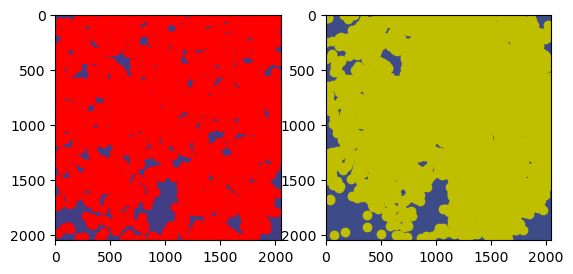

In [8]:
GS_cy7_norm = norm_image_func(GS_cy7)
GS_cy7_filtered = filter_func([300,None], GS_cy7_norm)

MERFISH_cy7_norm = norm_image_func(MERFISH_cy7)
MERFISH_cy7_filtered = filter_func([300,None], MERFISH_cy7_norm)

coordinates_GS_cy7 = peak_local_max(GS_cy7_filtered, min_distance=2, threshold_rel=0.08)
coordinates_MERFISH_cy7 = peak_local_max(MERFISH_cy7_filtered, min_distance=2, threshold_rel=0.09)

plt.subplot(1,2,1)
plt.imshow(GS_cy7_filtered)
plt.plot(coordinates_GS_cy7[:, 1], coordinates_GS_cy7[:, 0], 'ro')

plt.subplot(1,2,2)
plt.imshow(MERFISH_cy7_filtered)
plt.plot(coordinates_MERFISH_cy7[:, 1], coordinates_MERFISH_cy7[:, 0], 'yo')

SNR Guidestar: 2.7483945112302934
SNR MERFISH: 1.354599124594907


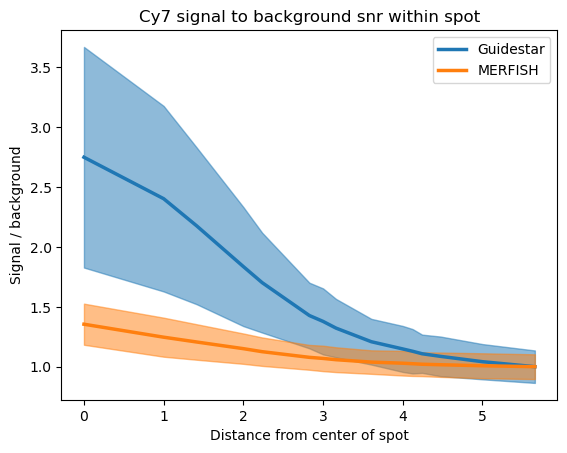

In [ ]:
sample_size = 500

GS_intensities_region = []
GS_dists_region = []
MERFISH_intensities_region = []
MERFISH_dists_region = []

filtered_GS_cy7_coords = coordinates_GS_cy7[np.logical_and(coordinates_GS_cy7 >= 20, coordinates_GS_cy7 <= 2028).all(axis=1)]
filtered_MERFISH_cy7_coords = coordinates_MERFISH_cy7[np.logical_and(coordinates_MERFISH_cy7 >= 20, coordinates_MERFISH_cy7 <= 2028).all(axis=1)]

coordinates_GS_cy7_sample = filtered_GS_cy7_coords[np.random.choice(filtered_GS_cy7_coords.shape[0], sample_size, replace=False)]
coordinates_MERFISH_cy7_sample = filtered_MERFISH_cy7_coords[np.random.choice(filtered_MERFISH_cy7_coords.shape[0], sample_size, replace=False)]

for spot in range(sample_size):
    y_GS = coordinates_GS_cy7_sample[spot,1]
    x_GS = coordinates_GS_cy7_sample[spot,0]
    y_MERFISH = coordinates_MERFISH_cy7_sample[spot,1]
    x_MERFISH = coordinates_MERFISH_cy7_sample[spot,0]
    
    GS_intensities_region_spot = []
    GS_dists_region_spot = []
    MERFISH_intensities_region_spot = []
    MERFISH_dists_region_spot = []
    
    for x_px in range(x_GS-4,x_GS+5):
        for y_px in range(y_GS-4,y_GS+5):
            px_intensity = GS_cy7_norm[x_px,y_px]
            px_dist = sqrt(np.power(y_GS-y_px,2)+np.power(x_GS-x_px,2))
            
            GS_intensities_region_spot.append(px_intensity)
            GS_dists_region_spot.append(px_dist)
            
    for x_px in range(x_MERFISH-4,x_MERFISH+5):
        for y_px in range(y_MERFISH-4,y_MERFISH+5):
            px_intensity = MERFISH_cy7_norm[x_px,y_px]
            px_dist = sqrt(np.power(y_MERFISH-y_px,2)+np.power(x_MERFISH-x_px,2))
            
            MERFISH_intensities_region_spot.append(px_intensity)
            MERFISH_dists_region_spot.append(px_dist)
            
    spot_GS_df = pd.DataFrame({'intensity':GS_intensities_region_spot,'dist':GS_dists_region_spot})
    spot_MERFISH_df = pd.DataFrame({'intensity':MERFISH_intensities_region_spot,'dist':MERFISH_dists_region_spot})
    spot_GS_df['snr'] = spot_GS_df['intensity'] / spot_GS_df['intensity'].loc[spot_GS_df['dist']==spot_GS_df['dist'].max()].mean()
    spot_MERFISH_df['snr'] = spot_MERFISH_df['intensity'] / spot_MERFISH_df['intensity'].loc[spot_MERFISH_df['dist']==spot_MERFISH_df['dist'].max()].mean()
    
    GS_intensities_region.extend(spot_GS_df['snr'].tolist())
    GS_dists_region.extend(spot_GS_df['dist'].tolist())
    MERFISH_intensities_region.extend(spot_MERFISH_df['snr'].tolist())
    MERFISH_dists_region.extend(spot_MERFISH_df['dist'].tolist())

GS_df = pd.DataFrame({'intensity':GS_intensities_region,'dist':GS_dists_region})
MERFISH_df = pd.DataFrame({'intensity':MERFISH_intensities_region,'dist':MERFISH_dists_region})

GS_avg_intensity = []
MERFISH_avg_intensity = []

GS_std_intensity = []
MERFISH_std_intensity = []

dist_ls = []

for d in np.unique(GS_dists_region):
    dist_ls.append(d)
    GS_avg_intensity.append(GS_df['intensity'].loc[GS_df['dist']==d].mean())
    MERFISH_avg_intensity.append(MERFISH_df['intensity'].loc[MERFISH_df['dist']==d].mean())
    
    GS_std_intensity.append(GS_df['intensity'].loc[GS_df['dist']==d].std())
    MERFISH_std_intensity.append(MERFISH_df['intensity'].loc[MERFISH_df['dist']==d].std())

GS_avg_intensity = np.array(GS_avg_intensity)
GS_std_intensity = np.array(GS_std_intensity)
MERFISH_avg_intensity = np.array(MERFISH_avg_intensity)
MERFISH_std_intensity = np.array(MERFISH_std_intensity)
      
fig,ax=plt.subplots() 
ax.plot(dist_ls,GS_avg_intensity,color='tab:blue', label='Guidestar', linewidth = 2.5)
ax.plot(dist_ls,MERFISH_avg_intensity,color='tab:orange', label='MERFISH', linewidth = 2.5)

ax.fill_between(dist_ls,GS_avg_intensity-GS_std_intensity,GS_avg_intensity+GS_std_intensity,color='tab:blue',alpha=0.5)
ax.fill_between(dist_ls,MERFISH_avg_intensity-MERFISH_std_intensity,MERFISH_avg_intensity+MERFISH_std_intensity,color='tab:orange',alpha=0.5)

ax.set_xlabel('Distance from center of spot')
ax.set_ylabel('Signal / background')
ax.legend(loc='upper right')
ax.set_title('Cy7 signal to background snr within spot')

# SNR at center of spot (distance 0)
print('SNR Guidestar:', GS_avg_intensity[0])
print('SNR MERFISH:', MERFISH_avg_intensity[0])
